In [1]:
# Copyright 2023 Andrew Lehr
# The MIT LICENSE

# Dynamic control of neural manifolds
#### Lehr, Kumar, & Tetzlaff

####
### Code to produce Figure 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import os

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from submanifolds.utils import get_root
from submanifolds.ringnet.network import RingNetworkVariableSpeed
from submanifolds.ringnet import Parameters
from submanifolds.ringnet import Plot
from submanifolds.utils import get_root

### Color palettes

In [2]:
colors = ['#586ba4', '#f68e5f', '#f5dd90',  
          '#067d7a', '#77c1b3',  '#b63653',
          '#6d2a2a', '#361a1a', '#191414', '#465865', '#928876',
          '#fc9234', '#fd6626', '#44867d', '#177070', '#404a50']

### Directories

In [3]:
root = get_root()
save_figs_flag = 0

# Figure storage
fig_top_dir = root + 'figures/'
fig_dir = fig_top_dir + 'figure_3/'

# Data storage
data_top_dir = root + 'data/'
data_dir = data_top_dir + 'shape_control/'

if not os.path.isdir(fig_top_dir):
    os.mkdir(fig_top_dir)
    print('Created ' + fig_top_dir)
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)
    print('Created ' + fig_dir)
else:
    print('fig dir exists')

if not os.path.isdir(data_top_dir):
    os.mkdir(data_top_dir)
    print('Created ' + data_top_dir)
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    print('Created ' + data_dir)
else:
    print('fig dir exists')

fig dir exists
fig dir exists


### Input functions

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

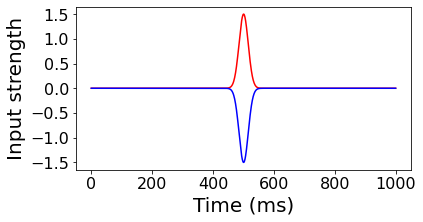

In [4]:
def gaussian(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def rect(T,a,x0,x1):
    resp = np.zeros(T)
    resp[x0:x1] = a
    return resp

T = 1001
I_ext = gaussian(np.arange(T), 1.5, T/2, 15)
I_ext_rect = rect(T,1.5,450,550)
plt.figure(figsize=(6,3))
I_ext = gaussian(np.arange(T), 1.5, T/2, 15)
plt.plot(I_ext, 'r')
I_ext = gaussian(np.arange(T), -1.5, T/2, 15)
plt.plot(I_ext, 'b')
plt.xlabel('Time (ms)',fontsize=20)
plt.ylabel('Input strength',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

### Parameters

In [5]:
sigma = 0.04
shift = 0.04
_w_E = 5 
N = 1000
T = 1001 
tau = 100 

n_seeds = 1
seeds = np.arange(n_seeds)

# speed control
speeds = [2.36]
n_speeds = len(speeds)

# shape control
shapes = np.arange(-2.5,3,0.25) #np.arange(-1.5,2.5,0.5) #np.arange(-1,2.5,0.5)
n_shapes = len(shapes)
t_shape_input = (T-1)/2
sd_shape_input = 12 #25

# subspaces
perc_sel = [0] #np.arange(0).round(2)
n_perc_sel = len(perc_sel)

# shape 2 -- activation function maxima
r_max_vals = [0] #[-0.5,-0.3,0,0.5,1]
n_r_max_vals = len(r_max_vals)
r_max = np.ones((T,N))

active_neurons = np.zeros((n_perc_sel,n_speeds,n_shapes,n_seeds,T))
average_rate = np.zeros((n_perc_sel,n_speeds,n_shapes,n_seeds,T))
raster = np.zeros((n_perc_sel,n_speeds,n_shapes,n_seeds,N,T))

In [6]:
n_speeds * n_shapes * n_perc_sel * n_r_max_vals * n_seeds

22

## Analysis functions

In [7]:
def center_raster(raster, normalize=True):
    # center the data
    R_centered = raster - raster.mean(axis=1, keepdims=True)
    if normalize:
        std = raster.std(axis=1, keepdims=True)
        R_centered = np.divide(R_centered, std, where=std!=0)
    return R_centered

In [8]:
def compute_pca(raster, n_components=2, normalize=True, compute_trajectory=False):

    # center and normalize, returns 
    centered_raster = center_raster(raster, normalize)
        
    # compute PCA
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(centered_raster.T)

    if compute_trajectory:
        # project onto PCs
        trajectory = project_onto_basis(centered_raster, pca.components_)
    else:
        trajectory = None
    
    return pca, trajectory, centered_raster

In [9]:
def project_onto_basis(raster, basis):
    return basis @ raster

In [10]:
def compute_trajectory_perturbation(trajectory_1, trajectory_2, t_center=t_shape_input, t_half_width=2*sd_shape_input):

    t0 = int(t_center - t_half_width)
    t1 = int(t_center + t_half_width)
    input_range = np.arange(t0,t1)
    
    diff = np.sqrt(np.sum((trajectory_1 - trajectory_2)**2, axis=0))
    peak_loc = t0 + np.argmax(diff[input_range])
    sign_diff = np.sign(np.sqrt(np.sum(trajectory_1[:,peak_loc]**2)) - np.sqrt(np.sum(trajectory_2[:,peak_loc]**2)))
    max_diff = sign_diff * diff[peak_loc] / np.sqrt(np.sum(trajectory_2[:,peak_loc]**2))

    return max_diff

In [11]:
def compute_trajectory_perturbation_from_raster(raster_1, raster_2, basis, t_center=t_shape_input, t_half_width=2*sd_shape_input):

    tol = .00001
    if (np.abs(raster_1.mean(axis=1)) > tol).any() or (np.abs(raster_2.mean(axis=1)) > tol).any():
        print("NOT CENTERED!")

    trajectory_1 = project_onto_basis(raster_1, basis)
    trajectory_2 = project_onto_basis(raster_2, basis)

    max_diff = compute_trajectory_perturbation(trajectory_1, trajectory_2, t_center, t_half_width)

    return max_diff

In [12]:
def compute_trajectory_rotational_speed(raster, basis):
    trajectory = project_onto_basis(raster, basis)
    analytic_signal = hilbert(trajectory)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    initial_phase = np.min(instantaneous_phase, axis=1, keepdims=True)
    instantaneous_phase = instantaneous_phase - initial_phase
    n_rotations = np.mean(np.max(instantaneous_phase, axis=1, keepdims=True)/(2*np.pi))
    return n_rotations

In [13]:
def compute_bump_speed(raster, thr_act = 0, thr_sep = 500):
    N = np.shape(raster)[0]
    T = np.shape(raster)[1]
    bump_center = np.zeros(T)
    for t in range(T):
        neurons_above_thr = np.where(raster[:,t] > thr_act)[0]
        if (np.max(neurons_above_thr) - np.min(neurons_above_thr)) > thr_sep:
            neurons_above_thr[neurons_above_thr<thr_sep] += N
        bump_center[t] = np.mean(neurons_above_thr) % N

    bump_speed = (bump_center[1:] - bump_center[:-1]) % N
    return bump_center, bump_speed

In [14]:
def compute_maximum_relative_bump_width(active_neurons, active_neurons_ref, t_center=t_shape_input, t_half_width=2*sd_shape_input):
    t0 = int(t_center - t_half_width)
    t1 = int(t_center + t_half_width)
    input_range = np.arange(t0,t1)
    
    bump_width = (active_neurons[input_range] - active_neurons_ref[input_range]) / active_neurons_ref[input_range]
    max_loc = np.argmax(np.abs(bump_width))
    max_rel_width = bump_width[max_loc]
    return max_rel_width

In [15]:
def compute_subspace_angle(basis_1, basis_2):
    u, s, vh = np.linalg.svd(np.dot(basis_1, basis_2.T), full_matrices=True)
    angles = np.arccos(np.clip(s, -1, 1))*180/np.pi
    return angles.mean()

In [16]:
def compute_subspace_angle_from_raster(raster_1, raster_2):
    pca_1 = compute_pca(raster_1)[0]
    pca_2 = compute_pca(raster_2)[0]
    basis_1 = pca_1.components_
    basis_2 = pca_2.components_
    angle = compute_subspace_angle(basis_1, basis_2)
    return angle

In [17]:
class Status:
    def __init__(self, total_iterations):
        self.total_iterations = total_iterations
        self.current_iteration = 0

    def it(self):
        self.current_iteration +=1
        print('\r: ' + str(self.current_iteration) + '/' + str(self.total_iterations), end='')

In [18]:
def compile_aggregate_raster(rasters):
    shape = np.shape(rasters)
    N = np.shape(rasters)[-2]
    T = np.shape(rasters)[-1]
    
    joint_raster = np.zeros((N,1))
    for speed_i in range(n_speeds):
        for shape_i in range(n_shapes):
            joint_raster = np.concatenate([joint_raster, rasters[:,:,speed_i,shape_i]], axis=1)
        
    joint_raster = joint_raster[:,1:]
    return joint_raster

## Run simulations

In [19]:
for p_i, p in enumerate(perc_sel):
    for k, seed in enumerate(seeds):
        params_to_update = {'keys':     ['N','sigma_percent', 'shift_percent', 'T', '_w_E', 'p_inh', 'seed', 'stim', 'type'], 
                            'setting':  [N, sigma, shift, T, _w_E, p, seed, 'transient', 'projection']}

        params = Parameters(params_to_update)

        # generate initial condition
        S = speeds[0]*np.ones(T)
        net = RingNetworkVariableSpeed(params, S=S, tau=tau, r_max=r_max) 
        initial_t = 250
        center = 0
        x = net.params.x
        width = int(net.params.sigma)
        max_active = net.params.P * r_max[0]
        initial_r = max_active * np.exp(-0.5 * (x - center)**2 / (width)**2)
        params.initial_r = initial_r
        net.run()
        initial_r = net.R[:,initial_t]
        #plt.plot(initial_r)
        params.initial_r = initial_r

        for j, A in enumerate(shapes):
            I_ext = gaussian(np.arange(T), A, t_shape_input, sd_shape_input)

            for i, I_E in enumerate(speeds):
                #I_ext = gaussian(np.arange(T), A, t_shape_input, sd_shape_input[i])
                S = I_E*np.ones(T)
                net = RingNetworkVariableSpeed(params, S=S, tau=tau, r_max=r_max, I_ext=I_ext) 
                net.run()
                active_neurons[p_i,i,j,k,:] = np.sum(net.R > 0, axis=0)
                average_rate[p_i,i,j,k,:] = np.mean(net.R, axis=0)
                raster[p_i,i,j,k,:,:] = net.R
    print(p)

/home/andrew/Documents/projects/submanifolds/submission_dynamic_control/code/submanifolds/ringnet/parameters.py:66: UserWarning: Recurrent weights were rescaled due to selective inhibition and transient excitatory burst input.
  warnings.warn('Recurrent weights were rescaled due to selective inhibition and transient excitatory burst input.')


0


### Figure 3a: Input current and bump width

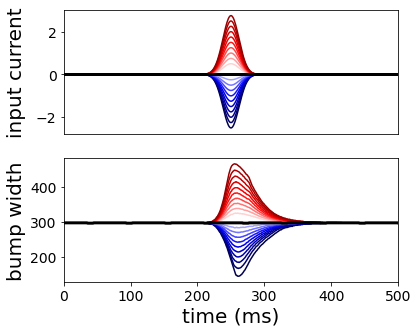

In [62]:
fname='input_current_and_bump_width'

fig, ax = plt.subplots(2,1, figsize=(6,5))

perc = 0
speed = 0
seed = 0

for traj in range(n_shapes):
    point = (perc, speed, traj, seed)
    ax[0].plot(gaussian(np.arange(T), shapes[traj], t_shape_input, sd_shape_input), color=colors_seismic[traj], label='$E-I=$' + str(shapes[traj]))
ax[0].plot(gaussian(np.arange(T), shapes[10], t_shape_input, sd_shape_input), color='black', linewidth=3)

ax[0].set_xticks([])
ax[0].set_xlim(250,750)
ax[0].set_ylabel('input current', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=14)


# bump size
perc = 0
speed = 0
seed = 0

for traj in range(n_shapes):
    point = (perc, speed, traj, seed)
    ax[1].plot(active_neurons[point], color=colors_seismic[traj])
ax[1].plot(active_neurons[perc, speed, 10, seed], color='black', linewidth=3)


# plots are all zoomed in onto one period between 250 and 750 ms
ax[1].set_xticks(np.arange(250,751,100), np.arange(0,501,100))
ax[1].set_xlim(250,750)

ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_xlabel('time (ms)', fontsize=20)
ax[1].set_ylabel('bump width', fontsize=20)

fig.align_ylabels()

if save_figs_flag:
    plt.savefig(fig_dir+fname + '.png', dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname + '.pdf', bbox_inches="tight")
plt.show()

### Figure 3b: Plot example rasters

In [20]:
plot = Plot()

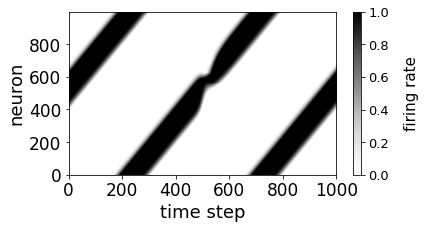

In [52]:
perc = 0
speed = 0
traj = 1
seed = 0
point = (perc, speed, traj, seed)
plot.activity_raster(raster[point])

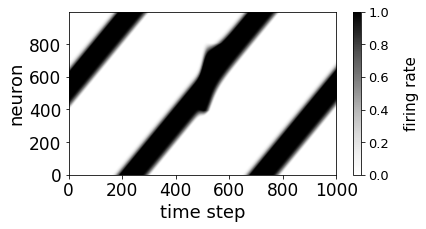

In [61]:
perc = 0
speed = 0
traj = 20
seed = 0
point = (perc, speed, traj, seed)
plot.activity_raster(raster[point])

### Compute basis for baseline PCA space, projections into that space, radius, and bump width

In [35]:
colors_seismic = plt.cm.seismic(np.linspace(0,1,n_shapes+1))

In [36]:
perc = 0
speed = 0
traj = 10
seed = 0
point = (perc, speed, traj, seed)

pca_baseline, _, raster_centered_ = compute_pca(raster[point], n_components=6)

In [37]:
basis = pca_baseline.components_

In [38]:
perc = 0
speed = 0
seed = 0
joint_raster = np.zeros((N,1))
for traj in range(n_shapes):
    point = (perc, speed, traj, seed)
    joint_raster = np.concatenate([joint_raster, raster[point]], axis=1)

joint_raster = joint_raster[:,1:]
joint_pca, _, raster_centered = compute_pca(joint_raster, n_components=6)

In [39]:
joint_pca.explained_variance_ratio_.cumsum()

array([0.27782646, 0.55406181, 0.70459035, 0.85276005, 0.89695406,
       0.94052799])

In [43]:
prj_rad = np.zeros((3, n_shapes, int(T/2)))

for i in range(n_shapes):
    prj = project_onto_basis(raster_centered[:,i*T + int(T/4): (i)*T + int(3*T/4)], basis)

    prj_rad[0, i,:] = np.sqrt(np.sum(prj[:2,:]**2, axis=0)) 
    prj_rad[1, i,:] = np.sqrt(np.sum(prj[2:4,:]**2, axis=0)) 
    prj_rad[2, i,:] = np.sqrt(np.sum(prj[4:,:]**2, axis=0)) 

### Figure 3d,e,f

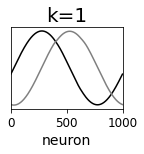

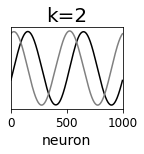

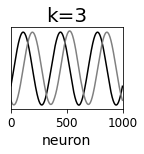

In [44]:
black_gray = ['black', 'gray']
for j in range(3):
    fname = 'principal_components_k=' + str(j+1)
    fig, ax = plt.subplots(1,1, figsize=(2,1.5))
    for i in range(2):
        ax.plot(basis[2*j+i,:], color=black_gray[i])
    ax.set_xticks([0,500,1000], [0,500,1000], fontsize=12)
    ax.set_xlabel('neuron', fontsize=14)
    ax.set_yticks([])
    ax.set_xlim(0,1000)
    ax.set_title('k='+str(j+1), fontsize=20)
    if save_figs_flag:
        plt.savefig(fig_dir+fname + '.png', dpi=200, bbox_inches="tight")
        plt.savefig(fig_dir+fname + '.pdf', bbox_inches="tight")
    plt.show()

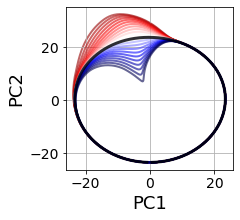

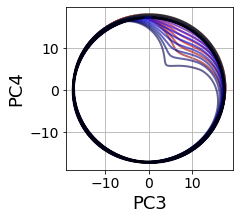

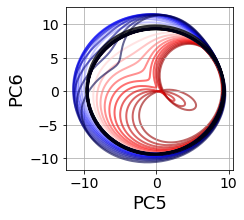

In [45]:
for j in range(3):
    fname = 'projection_into_pc_space_k=' + str(j+1)
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    for i in range(n_shapes):
        prj = project_onto_basis(raster_centered[:,i*T + int(T/4): (i)*T + int(3*T/4)], basis)
        ax.plot(*prj[2*j:2*(j+1),:],linewidth=2, zorder=n_shapes-i, alpha=0.6, color=colors_seismic[i])
    
    i = 10
    prj = project_onto_basis(raster_centered[:,i*T + int(T/4): (i)*T + int(3*T/4)], basis)
    ax.plot(*prj[2*j:2*(j+1),:],linewidth=3, zorder=100, alpha=.8, color='black')
    ax.grid()
    
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('PC'+str(2*j+1), fontsize=18)
    ax.set_ylabel('PC'+str(2*(j+1)), fontsize=18)
    if save_figs_flag:
        plt.savefig(fig_dir+fname + '.png', dpi=200, bbox_inches="tight")
        plt.savefig(fig_dir+fname + '.pdf', bbox_inches="tight")
    plt.show()

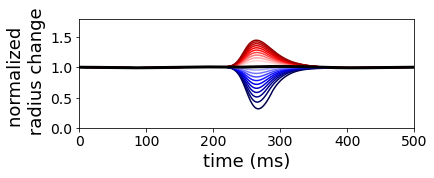

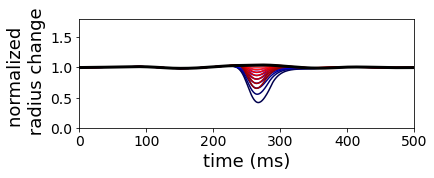

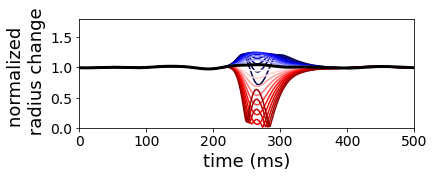

In [46]:
baseline_traj = np.where(shapes == 0)[0][0]
for j in range(3):
    fname = 'normalized_radius_change_k=' + str(j+1)
    fig, ax = plt.subplots(1,1, figsize=(6,2))
    for i in range(n_shapes):
        ax.plot(prj_rad[j,i,:]/np.mean(prj_rad[j,i,:200]), color=colors_seismic[i])
    
    ax.plot(prj_rad[j,baseline_traj,:]/np.mean(prj_rad[j,baseline_traj,:200]),color='black', linewidth=3)
    
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # X-AXIS LEFT PLOTS
    ax.set_xlim(0.,500)
    ax.set_xlabel('time (ms)', fontsize=18)
    
    # Y-AXIS LEFT PLOTS
    ax.set_ylabel('normalized \n radius change', fontsize=18)
    ax.set_ylim(0.,1.8)
    ax.set_yticks(np.arange(0,2,.5))
    if save_figs_flag:
        plt.savefig(fig_dir+fname + '.png', dpi=200, bbox_inches="tight")
        plt.savefig(fig_dir+fname + '.pdf', bbox_inches="tight")
    plt.show()

### Figure 3c

In [49]:
ind_diff = np.argmax(np.abs(active_neurons[perc, speed, 10, seed]- active_neurons[perc, speed, :, seed]), axis=1)
bump_widths = active_neurons[perc, speed, np.arange(n_shapes), seed, ind_diff]

In [50]:
bump_argextr = int(np.mean(np.concatenate([active_neurons[perc, speed, :10, seed].argmin(axis=1), active_neurons[perc, speed, 11:, seed].argmax(axis=1)])) - int(T/4))

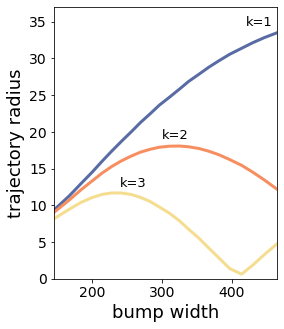

In [51]:
fname='trajectory_radius_vs_bump_width'

fig, ax = plt.subplots(1,1, figsize=(4,5))
for i in range(3):
    #ax.plot(bump_widths, prj_rad[i,:,np.argmax(prj_rad[0,-1,:])].T, color=colors[i], linewidth=3)
    ax.plot(bump_widths, prj_rad[i,:,bump_argextr].T, color=colors[i], linewidth=3)

ax.set_xlim(np.min(bump_widths), np.max(bump_widths))
ax.set_ylim(0,37)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('bump width', fontsize=18)
ax.set_ylabel('trajectory radius', fontsize=18)

ax.text(420,34.5, s='k=1',fontsize=13)
ax.text(300,19, s='k=2',fontsize=13)
ax.text(240,12.5, s='k=3',fontsize=13)

if save_figs_flag:
    plt.savefig(fig_dir+fname + '.png', dpi=200, bbox_inches="tight")
    #plt.savefig(fig_dir+fname + '.eps', bbox_inches="tight")
    plt.savefig(fig_dir+fname + '.pdf', bbox_inches="tight")
plt.show()